In [30]:
from pharynx_redox import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
from scipy import signal
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pformat
from tabulate import tabulate

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [63]:
meta_dir = Path("/Users/sean/code/pharynx_redox/data/paired_ratio")
raw_prof = da.load_all_cached_profile_data(meta_dir, '**/*single_unreg/*.nc')
reg_prof = da.load_all_cached_profile_data(meta_dir, r"**/*skfda_reg_wlam1e-1_bspline_basis/*.nc")

In [64]:
roi = 'posterior'
mvmt = da.load_all_movement(meta_dir).pivot_table(index=['experiment', 'animal'], columns=['pair', 'region']).reset_index()
m_0_0, m_0_1, m_1_0, m_1_1 = da.split_by_movement_types(mvmt, roi)

moving = pd.concat([m_0_1, m_1_0]).drop_duplicates().reset_index(drop=True)

In [65]:
from tabulate import tabulate

with open('/Users/sean/Desktop/table.rst', 'w') as f:
    f.write(tabulate(mvmt.head(3), tablefmt="rst", headers='keys'))

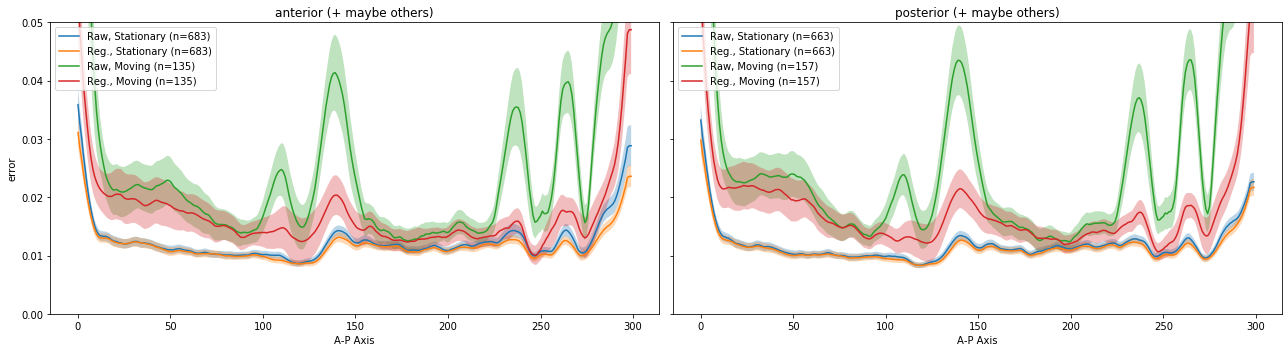

In [66]:
reload(da)

def loose_movement_stratefied_plots(mvmt, raw_prof, reg_prof, fname=None, param_dict=None):
    fig, axes = plt.subplots(1,2, figsize=(18,5), sharey='all')

    ylims = (0.00, 0.05)

    # Posterior
    roi = 'posterior'
    
    for ax, roi in zip(axes, ['anterior', 'posterior']):
        ax.set_title(f'{roi} (+ maybe others)')
        ax.set_ylim(*ylims)
        
        m_0_0, m_0_1, m_1_0, m_1_1 = da.split_by_movement_types(mvmt, roi, t=0)
        moving = pd.concat([m_0_1, m_1_0])
        
        ## stationary
        plots.plot_profile_avg_with_bounds(da.get_resid_rr(raw_prof)[m_0_0.index.values], ax=ax, label=f'Raw, Stationary (n={len(m_0_0.index.values)})')
        plots.plot_profile_avg_with_bounds(da.get_resid_rr(reg_prof)[m_0_0.index.values], ax=ax, label=f'Reg., Stationary (n={len(m_0_0.index.values)})')
        ## moving
        plots.plot_profile_avg_with_bounds(da.get_resid_rr(raw_prof)[moving.index.values], ax=ax, label=f'Raw, Moving (n={len(moving.index.values)})')
        plots.plot_profile_avg_with_bounds(da.get_resid_rr(reg_prof)[moving.index.values], ax=ax, label=f'Reg., Moving (n={len(moving.index.values)})')

        ax.legend(loc='upper left')
        ax.set_xlabel('A-P Axis')

    axes[0].set_ylabel('error')
    plt.tight_layout()
    
    if fname:
        plt.savefig(fname)
    
    if param_dict:
        param_str = pformat(param_dict)
        plt.suptitle(param_str)

loose_movement_stratefied_plots(mvmt, raw_prof, reg_prof)

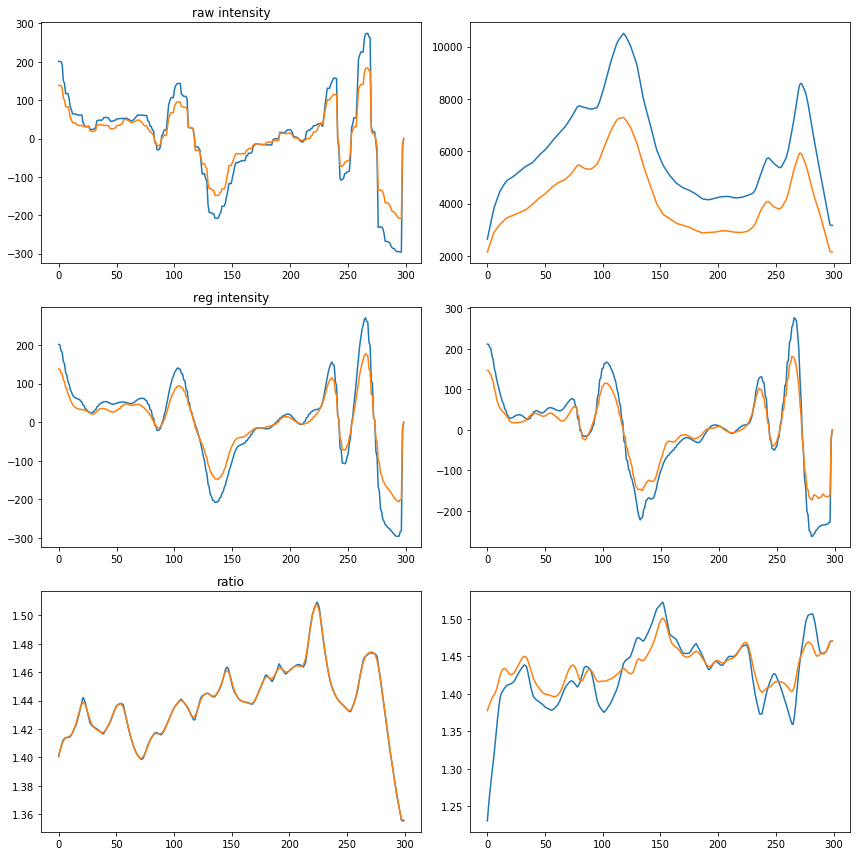

In [107]:
# stationary
idx = m_0_1.index.values
i = i + 1
fig, axes = plt.subplots(3,2, figsize=(12,12))
pair = 0
ax = axes[0,pair]
ax.set_title('raw intensity')
ax.plot(np.diff(raw_prof.sel(wavelength='410', pair=pair)[idx][i]), label='raw 410')
ax.plot(np.diff(raw_prof.sel(wavelength='470', pair=pair)[idx][i]), label='raw 410')
ax = axes[1,pair]
ax.set_title('reg intensity')
ax.plot(np.diff(reg_prof.sel(wavelength='410', pair=pair)[idx][i]), label='reg 410')
ax.plot(np.diff(reg_prof.sel(wavelength='470', pair=pair)[idx][i]), label='reg 410')
ax = axes[2,pair]
ax.set_title('ratio')
ax.plot(
    raw_prof.sel(wavelength='410', pair=pair)[idx][i] / raw_prof.sel(wavelength='470', pair=pair)[idx][i]
)
ax.plot(
    reg_prof.sel(wavelength='410', pair=pair)[idx][i] / reg_prof.sel(wavelength='470', pair=pair)[idx][i]
)


pair = 1
ax = axes[0,pair]
ax.plot(raw_prof.sel(wavelength='410', pair=pair)[idx][i], label='raw 410')
ax.plot(raw_prof.sel(wavelength='470', pair=pair)[idx][i], label='raw 410')
ax = axes[1,pair]
ax.plot(np.diff(reg_prof.sel(wavelength='410', pair=pair)[idx][i]), label='reg 410')
ax.plot(np.diff(reg_prof.sel(wavelength='470', pair=pair)[idx][i]), label='reg 410')
ax = axes[2,pair]
ax.plot(
    raw_prof.sel(wavelength='410', pair=pair)[idx][i] / raw_prof.sel(wavelength='470', pair=pair)[idx][i]
)
ax.plot(
    reg_prof.sel(wavelength='410', pair=pair)[idx][i] / reg_prof.sel(wavelength='470', pair=pair)[idx][i]
)

plt.tight_layout()

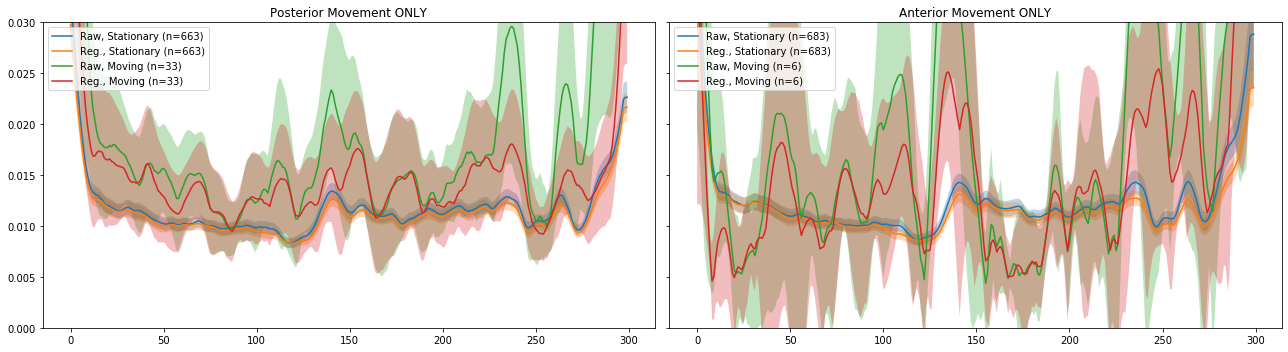

In [45]:
reload(da)

fig, axes = plt.subplots(1,2, figsize=(18,5), sharey='all')

ylims = (0, 0.03)

# Posterior
roi = 'posterior'
m_0_0, _, _, _ = da.split_by_movement_types(mvmt, roi)
m_0_1 = da.filter_only_moving_roi(mvmt, 0, roi)
m_1_0 = da.filter_only_moving_roi(mvmt, 1, roi)

moving = pd.concat([m_0_1, m_1_0]).drop_duplicates().reset_index(drop=True)

ax = axes[0]
ax.set_ylim(*ylims)
ax.set_title('Posterior Movement ONLY')
## stationary
plots.plot_profile_avg_with_bounds(da.get_resid_rr(raw_prof)[m_0_0.index.values], ax=ax, label=f'Raw, Stationary (n={len(m_0_0.index.values)})')
plots.plot_profile_avg_with_bounds(da.get_resid_rr(reg_prof)[m_0_0.index.values], ax=ax, label=f'Reg., Stationary (n={len(m_0_0.index.values)})')
## moving
plots.plot_profile_avg_with_bounds(da.get_resid_rr(raw_prof)[moving.index.values], ax=ax, label=f'Raw, Moving (n={len(moving.index.values)})')
plots.plot_profile_avg_with_bounds(da.get_resid_rr(reg_prof)[moving.index.values], ax=ax, label=f'Reg., Moving (n={len(moving.index.values)})')

ax.legend(loc='upper left')


# Anterior
roi = 'anterior'
m_0_0, _, _, _ = da.split_by_movement_types(mvmt, roi)
m_0_1 = da.filter_only_moving_roi(mvmt, 0, roi)
m_1_0 = da.filter_only_moving_roi(mvmt, 1, roi)

moving = pd.concat([m_0_1, m_1_0]).drop_duplicates()

ax = axes[1]
# ax.set_ylim(*ylims)
ax.set_title('Anterior Movement ONLY')
## stationary
plots.plot_profile_avg_with_bounds(da.get_resid_rr(raw_prof)[m_0_0.index.values], ax=ax, label=f'Raw, Stationary (n={len(m_0_0.index.values)})')
plots.plot_profile_avg_with_bounds(da.get_resid_rr(reg_prof)[m_0_0.index.values], ax=ax, label=f'Reg., Stationary (n={len(m_0_0.index.values)})')
## moving
plots.plot_profile_avg_with_bounds(da.get_resid_rr(raw_prof)[moving.index.values], ax=ax, label=f'Raw, Moving (n={len(moving.index.values)})')
plots.plot_profile_avg_with_bounds(da.get_resid_rr(reg_prof)[moving.index.values], ax=ax, label=f'Reg., Moving (n={len(moving.index.values)})')

ax.legend(loc='upper left')
plt.tight_layout()